### Задача
- Реализовать популяционный алгоритм **Gravitational Search Algorithm (GSA)** для решения задачи оптимизации
- Применить алгоритм для поиска кратчайшего пути в графе
- Сравнить результаты с эталонным алгоритмом A*
- Визуализировать процесс поиска и результаты

### Алгоритм гравитационного поиска (GSA)
GSA - это эвристический алгоритм оптимизации, основанный на законе всемирного тяготения Ньютона. В алгоритме:
- **Частицы** представляют возможные решения
- **Масса** частицы пропорциональна качеству решения
- **Гравитационная сила** между частицами определяет направление поиска
- Частицы с лучшими решениями притягивают остальные

---

## Импорт необходимых библиотек

In [20]:
import math
import random
from collections import deque
import matplotlib.pyplot as plt
import heapq

## Базовые структуры данных для работы с графом

### Класс Node
Представляет узел графа с координатами (x, y) и списком рёбер к соседним узлам.

In [21]:
class Node():
    def __init__(self, positionX, positionY):
        self.positionX = positionX
        self.positionY = positionY
        self.edges = dict()
        
    def get_pos(self):
        return (self.positionX, self.positionY)

### Класс Edge
Представляет ребро между двумя узлами с определённым весом (расстоянием).

In [22]:
class Edge():
    def __init__(self, nodeA: Node, nodeB: Node, weight):
        self.nodeA = nodeA
        self.nodeB = nodeB
        self.weight = weight

### Класс Graph
Основной класс для работы с графом. Включает методы для:
- **Добавления узлов и рёбер**
- **Поиска соседей** узла
- **Визуализации** графа и путей
- **Вычисления расстояний** между узлами
- **Поиска кластеров узлов**

In [23]:
class Graph():
    def __init__(self):
        self.nodes = dict()
        self.edges = list()

    def add_node(self, positionX, positionY):
        if (positionX, positionY) not in self.nodes:
            self.nodes[(positionX, positionY)] = Node(positionX, positionY)

    def add_edge(self, nodeA, nodeB, weight):
        if nodeA in self.nodes and nodeB in self.nodes:
            node_a_obj = self.nodes[nodeA]
            if nodeB in node_a_obj.edges:
                return

            node_b_obj = self.nodes[nodeB]
            edge = Edge(node_a_obj, node_b_obj, weight)
            self.edges.append(edge)
            node_a_obj.edges[nodeB] = edge
            node_b_obj.edges[nodeA] = edge
    
    def get_node(self, positionX, positionY):
        return self.nodes.get((positionX, positionY), None)
    
    def get_all_nodes(self): 
        return list(self.nodes.values())
    
    def get_edge(self, positionA, positionB):
        node1 = self.get_node(*positionA)
        if node1 and positionB in node1.edges:
            return node1.edges[positionB]
        return None
    
    def get_all_egdes(self):
        return self.edges
    
    def get_neighbors(self, positionX, positionY):
        node = self.get_node(positionX, positionY)
        if node:
            return list(node.edges.keys())
        return []
    
    def draw_graph(self):
        plt.figure(figsize=(10, 10))
        for edge in self.edges:
            x_values = [edge.nodeA.positionX, edge.nodeB.positionX]
            y_values = [edge.nodeA.positionY, edge.nodeB.positionY]
            plt.plot(x_values, y_values, 'b-', alpha=0.6, linewidth=1)
        
        for node in self.nodes.values():
            plt.plot(node.positionX, node.positionY, 'ro', markersize=8)
        
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title('Graph Visualization')
        plt.grid(True, alpha=0.3)
        plt.show()
        
    def draw_path(self, path, start_pos=None, end_pos=None):
        plt.figure(figsize=(12, 10))
        
        for edge in self.edges:
            x_values = [edge.nodeA.positionX, edge.nodeB.positionX]
            y_values = [edge.nodeA.positionY, edge.nodeB.positionY]
            plt.plot(x_values, y_values, 'lightblue', alpha=0.6, linewidth=1)
        
        for node in self.nodes.values():
            plt.plot(node.positionX, node.positionY, 'lightgray', markersize=8)
        
        if not path:
            print("Path is empty, cannot draw.")
            plt.show()
            return

        x_coords = [pos[0] for pos in path]
        y_coords = [pos[1] for pos in path]
        
        plt.plot(x_coords, y_coords, 'g-', linewidth=4, alpha=0.8, label='Path')
        
        for i, pos in enumerate(path):
            if i == 0 and start_pos:
                plt.plot(pos[0], pos[1], 'go', markersize=12, label='Start')
            elif i == len(path) - 1 and end_pos:
                plt.plot(pos[0], pos[1], 'ro', markersize=12, label='End')
            else:
                plt.plot(pos[0], pos[1], 'yo', markersize=10)
        
        total_distance = self.calculate_path_distance(path)
        plt.title(f'Graph with Path (Total Distance: {total_distance:.2f})')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
    
    def calculate_path_distance(self, path):
        if len(path) < 2:
            return 0
        
        total_distance = 0
        for i in range(len(path) - 1):
            current_pos = path[i]
            next_pos = path[i + 1]
            
            neighbors = self.get_neighbors(*current_pos)
            if next_pos not in neighbors:
                print(f"WARNING: Invalid transition in path: {current_pos} -> {next_pos}")
                return float('inf')
            
            edge = self.get_edge(current_pos, next_pos)
            if edge:
                total_distance += edge.weight
            else:
                print(f"ERROR: Edge not found for valid neighbors: {current_pos} -> {next_pos}")
                return float('inf')
        
        return total_distance

    def get_clusters(self):
        visited = set()
        components = []
        for node in self.nodes.values():
            if node not in visited:
                component = []
                q = deque([node])
                visited.add(node)
                while q:
                    current_node = q.popleft()
                    component.append(current_node)
                    for neighbor_key in current_node.edges:
                        neighbor_node = self.nodes[neighbor_key]
                        if neighbor_node not in visited:
                            visited.add(neighbor_node)
                            q.append(neighbor_node)
                components.append(component)
        return components
    
    def get_euclidean_distance(self, nodeA: Node, nodeB: Node):
        return math.sqrt((nodeA.positionX - nodeB.positionX) ** 2 + (nodeA.positionY - nodeB.positionY) ** 2)

## Генерация тестового графа

Функция `generate_graph` создаёт случайный граф с заданными параметрами:
- **Гексагональная упаковка** узлов для равномерного распределения
- **Связывание** каждого узла с ближайшими соседями
- **Обеспечение связности** графа путём соединения разных компонент

In [24]:
def generate_graph(height, width, nodes_num, radius, edges_per_node=3) -> Graph:
    graph = Graph()
    
    d = 2 * radius
    y_step = math.sqrt(3) * radius
    
    possible_positions = []
    
    row = 0
    y = radius
    while y + radius <= height:
        if row % 2 == 0:
            x = radius
            while x + radius <= width:
                possible_positions.append((x, y))
                x += d
        else:
            x = 2 * radius
            while x + radius <= width:
                possible_positions.append((x, y))
                x += d
        y += y_step
        row += 1

    if len(possible_positions) < nodes_num:
        raise ValueError("Cannot fit the required number of circles in the given area with the specified radius.")

    chosen_positions = random.sample(possible_positions, nodes_num)
    
    for pos in chosen_positions:
        graph.add_node(pos[0], pos[1])
        
    for node_key, node in graph.nodes.items():
        distances = []
        for other_key, other_node in graph.nodes.items():
            if node_key != other_key:
                dist = math.sqrt((node.positionX - other_node.positionX)**2 + (node.positionY - other_node.positionY)**2)
                distances.append((dist, other_key))
        
        distances.sort()
        
        for i in range(min(edges_per_node, len(distances))):
            dist, neighbor_key = distances[i]
            graph.add_edge(node_key, neighbor_key, dist)

    components = graph.get_clusters()

    if len(components) > 1:
        for i in range(len(components) - 1):
            node1 = random.choice(components[i])
            node2 = random.choice(components[i+1])
            
            dist = math.sqrt((node1.positionX - node2.positionX)**2 + (node1.positionY - node2.positionY)**2)
            graph.add_edge(node1.get_pos(), node2.get_pos(), dist)
                
    return graph

## Реализация частицы для алгоритма GSA

### Класс Particle
Представляет отдельную частицу в алгоритме GSA. Каждая частица:
- **Хранит путь** от начальной до конечной точки
- **Имеет массу** пропорциональную качеству решения
- **Обладает скоростью** для перемещения в пространстве поиска
- **Вычисляет приспособленность** на основе длины пути

Основные методы:
- `_generate_random_path()` - создание случайного валидного пути
- `_calculate_fitness()` - вычисление качества решения
- `update_position()` - обновление позиции под действием сил

In [ ]:
class Particle:
    def __init__(self, graph: Graph, start_pos, end_pos, max_path_length=20):
        self.graph = graph
        self.start_pos = start_pos
        self.end_pos = end_pos
        self.max_path_length = max_path_length
        
        
        self.path = [start_pos]
        self.velocity = []
        self.mass = 1.0
        self.fitness = float('inf')
        self.best_fitness = float('inf')
        self.best_path = [start_pos]
        
        
        self._generate_random_path()
        self._calculate_fitness()
    
    def _generate_random_path(self):
        current_pos = self.start_pos
        self.path = [current_pos]
        visited = {current_pos}
        
        for _ in range(self.max_path_length):
            if current_pos == self.end_pos:
                break
                
            neighbors = self.graph.get_neighbors(*current_pos)
            
            unvisited_neighbors = [n for n in neighbors if n not in visited]
            
            if not unvisited_neighbors:
                unvisited_neighbors = [n for n in neighbors if n != current_pos]
            
            if unvisited_neighbors:
                distances_to_end = []
                for neighbor in unvisited_neighbors:
                    dist = math.sqrt((neighbor[0] - self.end_pos[0])**2 + 
                                   (neighbor[1] - self.end_pos[1])**2)
                    distances_to_end.append((dist, neighbor))
                
                distances_to_end.sort()
                
                best_options = distances_to_end[:min(3, len(distances_to_end))]
                _, next_pos = random.choice(best_options)
                
                self.path.append(next_pos)
                visited.add(next_pos)
                current_pos = next_pos
            else:
                break
    
    def _calculate_fitness(self):
        if not self.path:
            self.fitness = float('inf')
            return
        
        if not self._is_path_valid():
            self.fitness = float('inf')
            return
        
        path_distance = self.graph.calculate_path_distance(self.path)
        
        if self.path[-1] != self.end_pos:
            end_distance = math.sqrt((self.path[-1][0] - self.end_pos[0])**2 + 
                                   (self.path[-1][1] - self.end_pos[1])**2)
            self.fitness = path_distance + end_distance * 100  
        else:
            self.fitness = path_distance
        
        if self.fitness < self.best_fitness:
            self.best_fitness = self.fitness
            self.best_path = self.path.copy()
    
    def _is_path_valid(self):
        if len(self.path) < 2:
            return True
            
        for i in range(len(self.path) - 1):
            current_pos = self.path[i]
            next_pos = self.path[i + 1]
            
            neighbors = self.graph.get_neighbors(*current_pos)
            if next_pos not in neighbors:
                return False
                
        return True
    
    def update_position(self, force):
        if len(force) == 0:
            return
            
        acceleration = [f / self.mass for f in force]
        
        if len(self.velocity) == 0:
            self.velocity = acceleration
        else:
            damping = 0.9
            for i in range(min(len(self.velocity), len(acceleration))):
                self.velocity[i] = self.velocity[i] * damping + acceleration[i]
        
        self._apply_velocity_to_path()
        self._calculate_fitness()
    
    def _apply_velocity_to_path(self):
        if not self.velocity:
            return
            
        velocity_magnitude = sum(abs(v) for v in self.velocity)
        modification_probability = min(0.3, velocity_magnitude / 10)
        
        new_path = [self.start_pos]
        current_pos = self.start_pos
        
        for i in range(1, self.max_path_length):
            if current_pos == self.end_pos:
                break
                
            neighbors = self.graph.get_neighbors(*current_pos)
            if not neighbors:
                break
                
            if random.random() < modification_probability:
                best_neighbor = min(neighbors, 
                                  key=lambda n: math.sqrt((n[0] - self.end_pos[0])**2 + 
                                                        (n[1] - self.end_pos[1])**2))
                current_pos = best_neighbor
            else:
                if i < len(self.path) and self.path[i] in neighbors:
                    current_pos = self.path[i]
                else:
                    current_pos = random.choice(neighbors)
            
            new_path.append(current_pos)
        
        self.path = new_path

## Основной алгоритм гравитационного поиска (GSA)

### Класс GravitationalSearchAlgorithm

Реализует алгоритм GSA

#### Физические принципы:
- **Гравитационная постоянная G** - уменьшается со временем
- **Масса частиц** - пропорциональна качеству решения
- **Силы притяжения** - между частицами с разным качеством

#### Основные этапы алгоритма:
1. **Инициализация популяции** случайных частиц
2. **Вычисление масс** на основе приспособленности
3. **Расчёт сил** взаимодействия между частицами
4. **Обновление позиций** частиц под действием сил
5. **Повторение** до достижения критерия остановки

#### Адаптация для поиска пути:
- Частицы представляют пути в графе
- Сила притяжения направляет к лучшим решениям
- Валидность путей поддерживается на каждом шаге

In [ ]:
class GravitationalSearchAlgorithm:
    def __init__(self, graph: Graph, start_pos, end_pos, population_size=30, max_iterations=100):
        self.graph = graph
        self.start_pos = start_pos
        self.end_pos = end_pos
        self.population_size = population_size
        self.max_iterations = max_iterations
        self.particles = []
        self.best_particle = None
        self.G = 100.0  
        self.alpha = 20.0
        
        self._initialize_population()
    
    def _initialize_population(self):
        for _ in range(self.population_size):
            particle = Particle(self.graph, self.start_pos, self.end_pos)
            self.particles.append(particle)
        
        self.best_particle = min(self.particles, key=lambda p: p.fitness)
    
    def _update_masses(self, iteration):
        
        fitnesses = [p.fitness for p in self.particles]
        best_fitness = min(fitnesses)
        worst_fitness = max(fitnesses)
        
        if worst_fitness == best_fitness:
            
            for particle in self.particles:
                particle.mass = 1.0
            return
        
        for particle in self.particles:
            if worst_fitness != best_fitness:
                mass = (particle.fitness - worst_fitness) / (best_fitness - worst_fitness)
                particle.mass = max(0.1, 1.0 - mass)  
            else:
                particle.mass = 1.0
    
    def _calculate_forces(self, iteration):
        forces = [[] for _ in range(self.population_size)]
        
        current_G = self.G * math.exp(-self.alpha * iteration / self.max_iterations)
        
        for i in range(self.population_size):
            total_force = []
            
            for j in range(self.population_size):
                if i != j:
                    force = self._calculate_force_between_particles(
                        self.particles[i], self.particles[j], current_G)
                    
                    if len(total_force) == 0:
                        total_force = force
                    else:
                        
                        for k in range(min(len(total_force), len(force))):
                            total_force[k] += force[k]
                        
                        if len(force) > len(total_force):
                            total_force.extend(force[len(total_force):])
            
            forces[i] = total_force
        
        return forces
    
    def _calculate_force_between_particles(self, particle1, particle2, G):
        if particle2.fitness >= particle1.fitness:
            return []  
        
        fitness_diff = abs(particle1.fitness - particle2.fitness) + 1e-10
        force_magnitude = G * particle1.mass * particle2.mass / fitness_diff
        
        force_components = []
        path_length = min(len(particle1.path), len(particle2.path))
        
        for i in range(path_length):
            
            force_components.append(random.uniform(-force_magnitude, force_magnitude))
        
        return force_components
    
    def run(self, verbose=True):
        fitness_history = []
        
        for iteration in range(self.max_iterations):
            
            self._update_masses(iteration)
            forces = self._calculate_forces(iteration)
            for i, particle in enumerate(self.particles):
                particle.update_position(forces[i])
            
            current_best = min(self.particles, key=lambda p: p.fitness)
            if current_best.fitness < self.best_particle.fitness:
                self.best_particle = current_best
            
            fitness_history.append(self.best_particle.fitness)
            
            if verbose and iteration % 10 == 0:
                print(f"Iteration {iteration}: Best fitness = {self.best_particle.fitness:.2f}")
                if not self.best_particle._is_path_valid():
                    print(f"WARNING: Invalid path detected at iteration {iteration}")
            
            if self.best_particle.path[-1] == self.end_pos and self.best_particle.fitness == self.graph.get_euclidean_distance(
                self.graph.get_node(*self.start_pos), self.graph.get_node(*self.end_pos)):
                if verbose:
                    print(f"Target reached at iteration {iteration}!")
                break
        
        return self.best_particle.best_path, fitness_history
    
    def get_best_path(self):
        return self.best_particle.best_path if self.best_particle else []

## Эталонный алгоритм A* для сравнения

### Класс AStarPathfinder

Реализует классический алгоритм A* для поиска кратчайшего пути:

#### Принцип работы:
- **Эвристическая функция** - оценка расстояния до цели
- **Приоритетная очередь** - выбор наиболее перспективных узлов
- **Гарантированно оптимальное решение** при допустимой эвристике

In [27]:
class AStarPathfinder:
    def __init__(self, graph: Graph):
        self.graph = graph
    
    def heuristic(self, pos1, pos2):
        return math.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
    
    def find_path(self, start_pos, end_pos):
        open_set = [(0, start_pos)]
        came_from = {}
        g_score = {start_pos: 0}
        f_score = {start_pos: self.heuristic(start_pos, end_pos)}
        
        while open_set:
            current_f, current = heapq.heappop(open_set)
            
            if current == end_pos:
                path = []
                while current in came_from:
                    path.append(current)
                    current = came_from[current]
                path.append(start_pos)
                return path[::-1]
            
            for neighbor in self.graph.get_neighbors(*current):
                edge = self.graph.get_edge(current, neighbor)
                if edge is None:
                    continue
                    
                tentative_g_score = g_score[current] + edge.weight
                
                if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + self.heuristic(neighbor, end_pos)
                    heapq.heappush(open_set, (f_score[neighbor], neighbor))
        
        return []

## Сравнение алгоритмов GSA и A*

### Функция compare_algorithms

Демонстрирует работу обоих алгоритмов на одном и том же графе:

#### Процесс сравнения:
1. **Генерация тестового графа** с заданными параметрами
2. **Случайный выбор** начальной и конечной точек
3. **Запуск A*** для получения оптимального решения
4. **Запуск GSA** с теми же начальными условиями
5. **Визуализация результатов** и **анализ сходимости**

#### Выходные данные:
- **Графическое сравнение** найденных путей
- **Численное сравнение** длин путей
- **График сходимости** GSA относительно оптимального решения A*

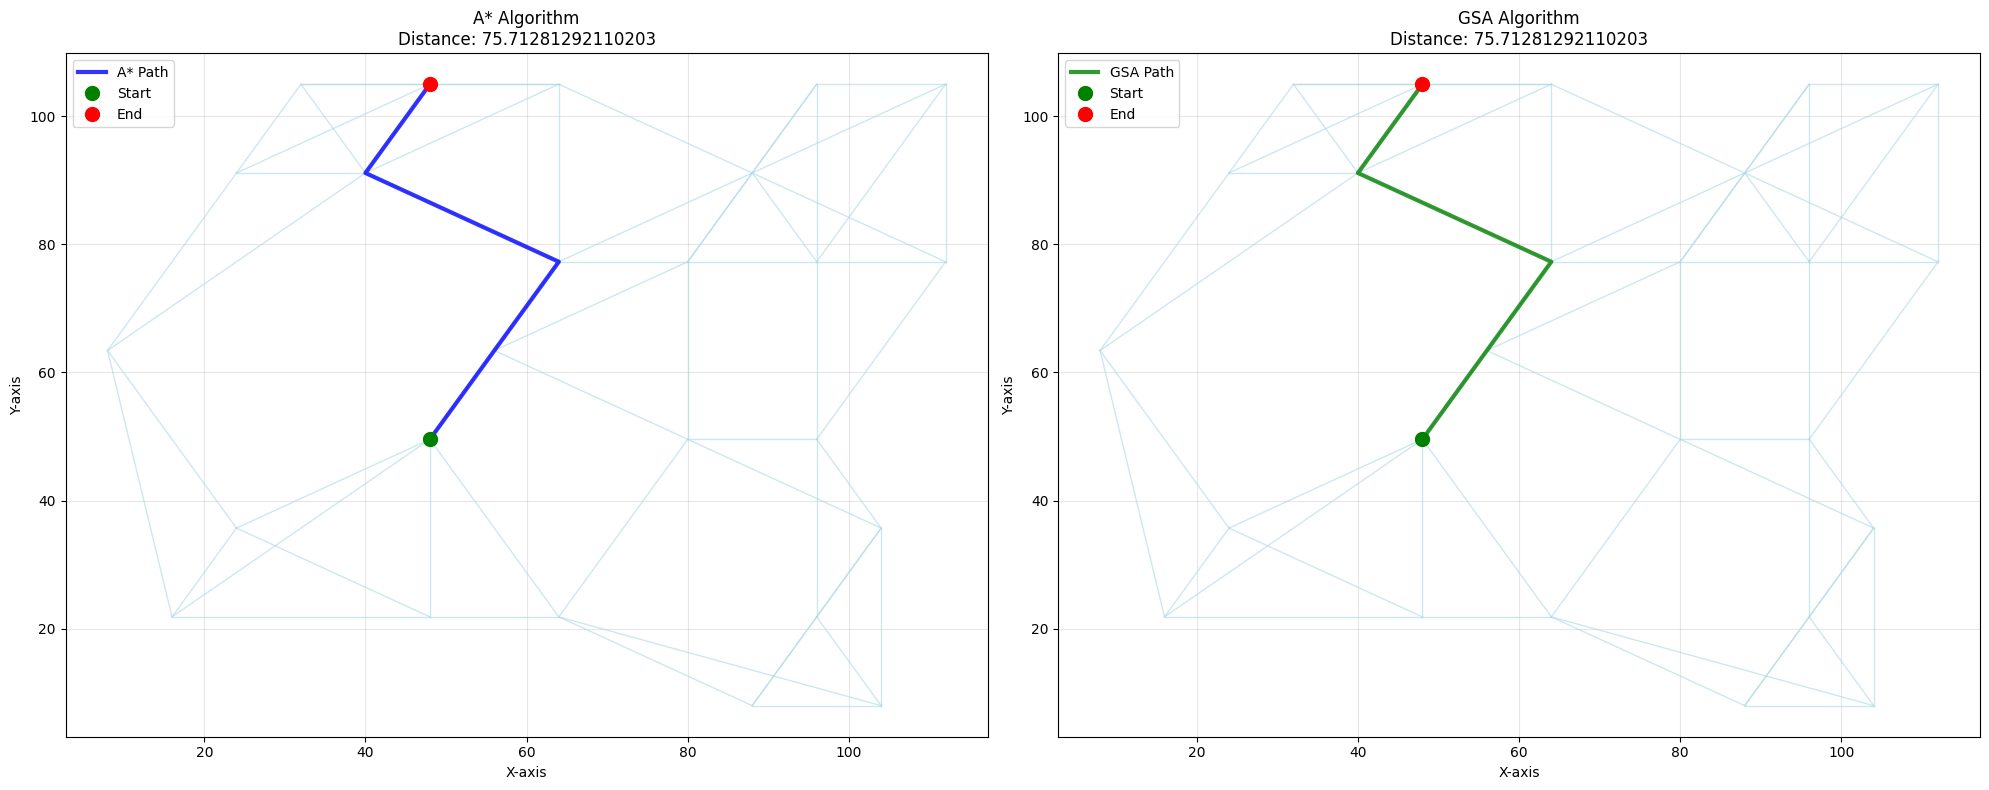

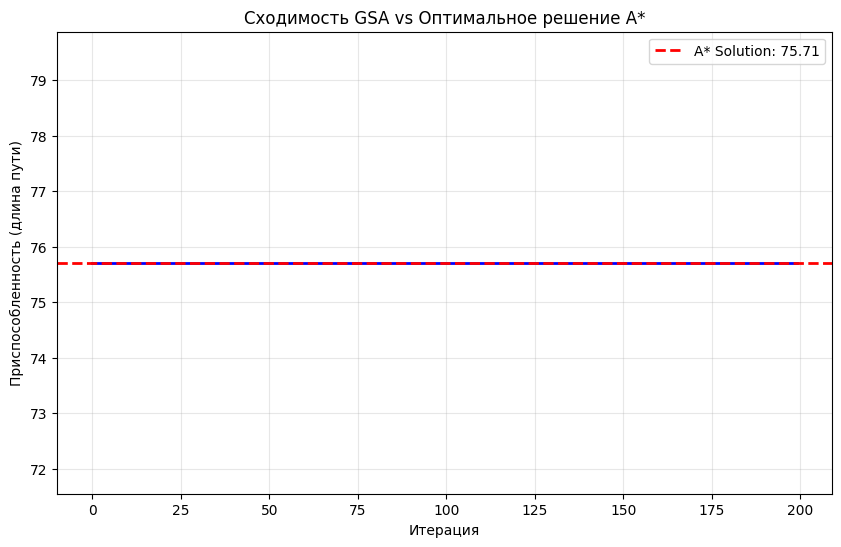

In [28]:
def compare_algorithms():
    test_graph = generate_graph(120, 120, 25, 8, edges_per_node=4)
    all_nodes = list(test_graph.nodes.keys())
    
    start_pos = random.choice(all_nodes)
    end_pos = random.choice([node for node in all_nodes if node != start_pos])
    
    astar = AStarPathfinder(test_graph)
    astar_path = astar.find_path(start_pos, end_pos)
    astar_distance = test_graph.calculate_path_distance(astar_path)
    
    gsa = GravitationalSearchAlgorithm(
        graph=test_graph, 
        start_pos=start_pos, 
        end_pos=end_pos, 
        population_size=50, 
        max_iterations=200
    )
    gsa_path, gsa_fitness_history = gsa.run(verbose=False)
    gsa_distance = test_graph.calculate_path_distance(gsa_path)
  


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # A* путь
    plt.sca(ax1)
    for edge in test_graph.edges:
        x_values = [edge.nodeA.positionX, edge.nodeB.positionX]
        y_values = [edge.nodeA.positionY, edge.nodeB.positionY]
        plt.plot(x_values, y_values, 'lightblue', alpha=0.6, linewidth=1)
    
    for node in test_graph.nodes.values():
        plt.plot(node.positionX, node.positionY, 'lightgray', markersize=6)
    
    if astar_path:
        x_coords = [pos[0] for pos in astar_path]
        y_coords = [pos[1] for pos in astar_path]
        plt.plot(x_coords, y_coords, 'b-', linewidth=3, alpha=0.8, label='A* Path')
        plt.plot(start_pos[0], start_pos[1], 'go', markersize=10, label='Start')
        plt.plot(end_pos[0], end_pos[1], 'ro', markersize=10, label='End')
    
    plt.title(f'A* Algorithm\nDistance: {astar_distance}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # GSA путь
    plt.sca(ax2)
    for edge in test_graph.edges:
        x_values = [edge.nodeA.positionX, edge.nodeB.positionX]
        y_values = [edge.nodeA.positionY, edge.nodeB.positionY]
        plt.plot(x_values, y_values, 'lightblue', alpha=0.6, linewidth=1)
    
    for node in test_graph.nodes.values():
        plt.plot(node.positionX, node.positionY, 'lightgray', markersize=6)
    
    if gsa_path:
        x_coords = [pos[0] for pos in gsa_path]
        y_coords = [pos[1] for pos in gsa_path]
        plt.plot(x_coords, y_coords, 'g-', linewidth=3, alpha=0.8, label='GSA Path')
        plt.plot(start_pos[0], start_pos[1], 'go', markersize=10, label='Start')
        plt.plot(end_pos[0], end_pos[1], 'ro', markersize=10, label='End')
    
    plt.title(f'GSA Algorithm\nDistance: {gsa_distance}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    if gsa_fitness_history:
        plt.figure(figsize=(10, 6))
        plt.plot(gsa_fitness_history, 'b-', linewidth=2)
        if astar_path:
            plt.axhline(y=astar_distance, color='r', linestyle='--', linewidth=2, label=f'A* Solution: {astar_distance:.2f}')
        plt.title('Сходимость GSA vs Оптимальное решение A*')
        plt.xlabel('Итерация')
        plt.ylabel('Приспособленность (длина пути)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

comparison_results = compare_algorithms()